# Lets understand the AI pipeline so far and next <br>
1. We cleaned the dataset. <br>
2. We use HDBSCAN to identify outliers. Input dataset was spatio-temporal, which means it is 3D HDBSCAN, so we identified dense in both space and time, called as Valid cluster and only spatially close but temporally isolated, we called it as a outlier. Output is saved in the csv file.<br>
3. GMM to generate soft clusters, it wants to know 2 things. <br>
---GMM(lat/lon) - For detecting hotspots, regions <br>
---HDBSCAN output - For filtering noise, hotspots. <br>
4. LSTN or GRU - Supervised learning is trained to predict the next cluster based on historical movements. Simple, it combines the identified clusters from GMM with timestampd and taxi.Example sequence for one taxi is, <br>

|Time|cluster ID|
|:----|:----|
|08:00:00|12|
|08:05:00|12|
|08:12:00|45|
|08:25:00|21|
|08:42:00|98|


# Gaussian Mixture Model (GMM) clustering! <br>
-Identify soft clusters based on probabilistic membership <br>
-Usefull for modeling overlapping regions (eg., taxi hotspots) <br>


In [29]:
# !pip install sklearn
# !pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension --sys-prefix
!jupyter nbextension install --py folium --sys-prefix


usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: kernel kernelspec migrate run troubleshoot

Jupyter command `jupyter-nbextension` not found.
usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing



1.Load HDBSCAN Output (Filtered) & Filter Out Outliers

In [3]:
import pandas as pd

# Load the HDBSCAN output
df = pd.read_csv("D:/Research/Papers/repo/IEEE_SubResizeUsingAIForFleetVehicles/Output/hdbscan_clustered_data.csv")  # update with your file path

# Remove outliers (cluster = -1 or is_outlier = True)
df_clean = df[df['is_outlier'] == False].copy()
df_clean.head(3)

,taxiid,timestamp,longitude,latitude,ts_num,cluster,is_outlier
0,6211,2008-02-02 13:30:49,116.35278,39.98036,1201959049,2043,0
1,6211,2008-02-02 13:30:54,116.35279,39.98036,1201959054,2043,0
2,6211,2008-02-02 13:30:59,116.35279,39.98037,1201959059,2043,0


2. Prepare Feature Matrix for GMM - Use Spatial coordinates.

In [5]:
X = df_clean[['latitude', 'longitude']].values

 4. Choose Optimal Number of Clusters with BIC = Bayesian Information Criterion. It measures how well the model fits the data while penalizing complexity. Lower BIC = better model (good fit, not too complex). Without BIC, there is a risk of bad fit, with BIC more reliable clustering. This helps automatically select how many clusters the GMM should use.Unlike DBSCAN/HDBSCAN (which automatically infer the number of clusters), GMM requires you to tell it how many Gaussian blobs to fit. range(2, 15) for GMM is a practical starting range.

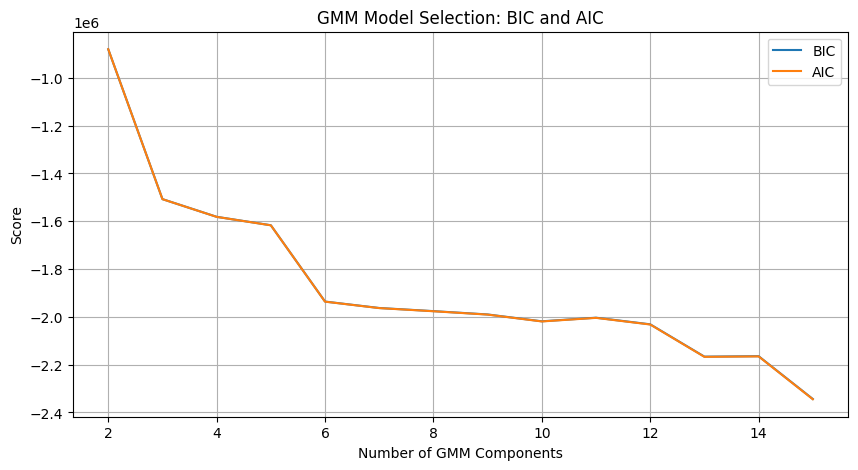

In [6]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

bics = []
aics = []
ks = range(2, 16)

for k in ks:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm.fit(X)
    bics.append(gmm.bic(X))
    aics.append(gmm.aic(X))

plt.figure(figsize=(10, 5))
plt.plot(ks, bics, label='BIC')
plt.plot(ks, aics, label='AIC')
plt.xlabel('Number of GMM Components')
plt.ylabel('Score')
plt.title('GMM Model Selection: BIC and AIC')
plt.legend()
plt.grid(True)
plt.show()

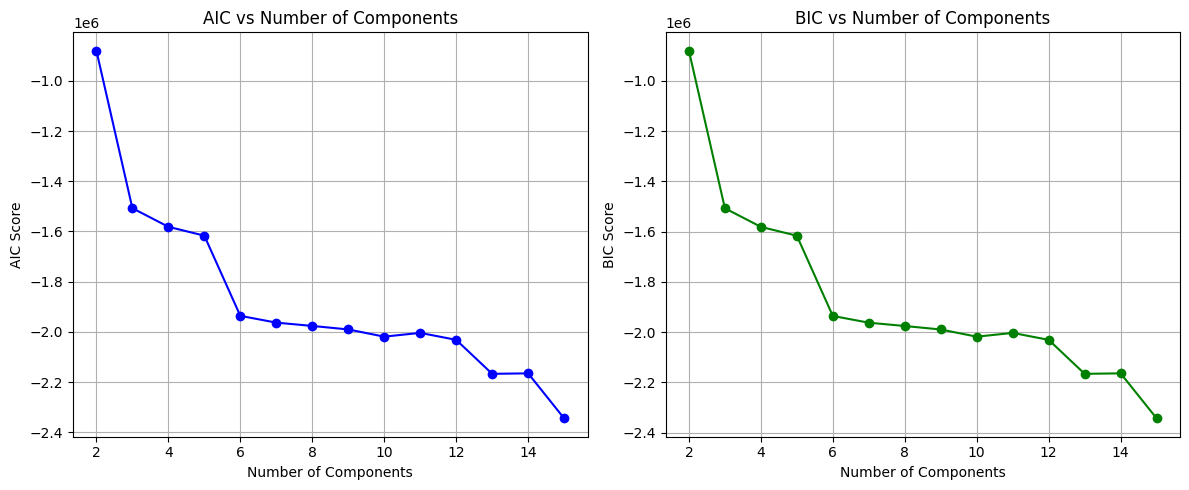

In [7]:
plt.figure(figsize=(12, 5))

# Plot AIC
plt.subplot(1, 2, 1)
plt.plot(ks, aics, marker='o', color='blue')
plt.title('AIC vs Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('AIC Score')
plt.grid(True)

# Plot BIC
plt.subplot(1, 2, 2)
plt.plot(ks, bics, marker='o', color='green')
plt.title('BIC vs Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('BIC Score')
plt.grid(True)

plt.tight_layout()
plt.show()

# 🔎 Observation from AIC & BIC plot: <br>
1.Both AIC and BIC steadily decrease from k=2 to k=15 <br>
2.No elbow point (i.e., no clear flattening) <br>
3.The model keeps improving slightly with more clusters <br>
# 🧠 Interpretation: <br>
1.The data is complex and benefits from more components <br>
2.But the improvement is incremental, not dramatic <br>
3.You're entering a zone of diminishing returns<br>
# What You Should Do Next
✅ Pick a Practical k. <br>
Since there's no clear “best” number, choose a value based on balance between:<br>
-Interpretability (smaller k) <br>
-Fit quality (larger k)<br>
Recommended: Choose k = 6, 8, or 10 <br>
These are: <br>
-Easy to interpret<br>
-Still within the range where BIC/AIC are improving<br>
-Not too complex for plotting or LSTM modeling lat<br>

# 📌 Next Steps <br>
🔹 Step 1: Fit Final GMM Model <br>

In [8]:
from sklearn.mixture import GaussianMixture

# Choose your preferred k (e.g., 8)
gmm = GaussianMixture(n_components=8, covariance_type='full', random_state=42)
df_clean['gmm_cluster'] = gmm.fit_predict(X)

In [10]:
df_clean.head(3)

,taxiid,timestamp,longitude,latitude,ts_num,cluster,is_outlier,gmm_cluster
0,6211,2008-02-02 13:30:49,116.35278,39.98036,1201959049,2043,0,3
1,6211,2008-02-02 13:30:54,116.35279,39.98036,1201959054,2043,0,3
2,6211,2008-02-02 13:30:59,116.35279,39.98037,1201959059,2043,0,3


🔹 Step 2: Add Confidence Score

In [12]:
probs = gmm.predict_proba(X)
df_clean['gmm_cluster_confidence'] = probs.max(axis=1)

🔹 Step 3: Visualize the GMM Clusters

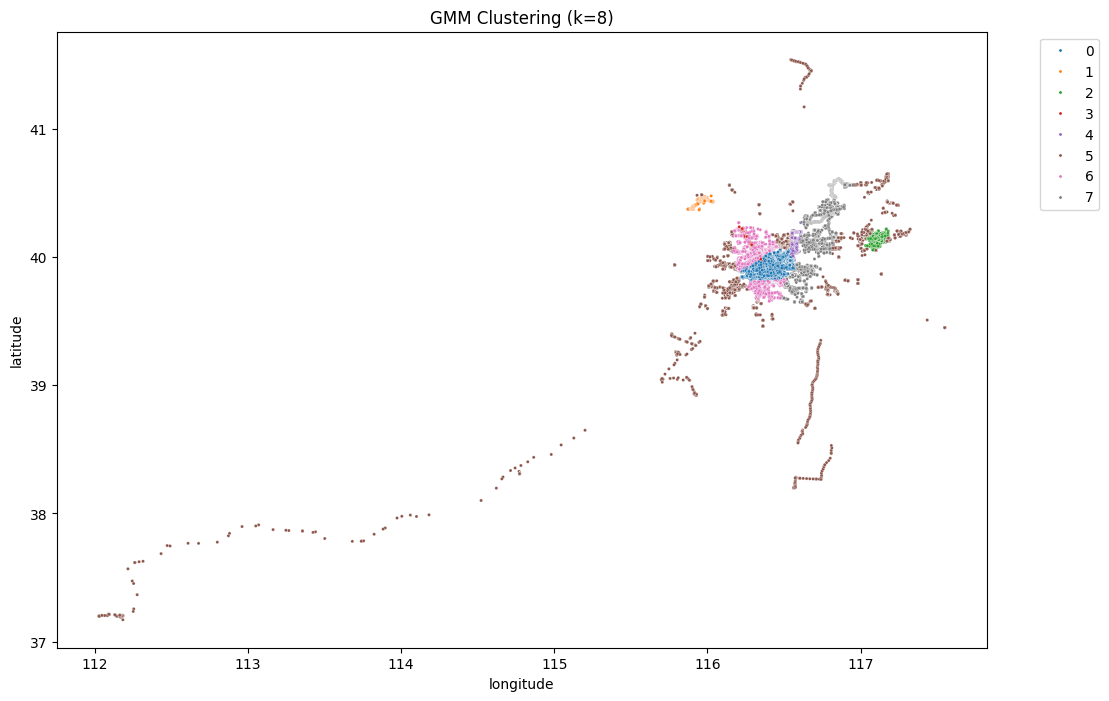

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='longitude', y='latitude',
    hue='gmm_cluster',
    data=df_clean,
    palette='tab10',
    s=5
)
plt.title('GMM Clustering (k=8)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

🔸 Plot Gaussian Ellipses (Optional)
If you want to show the shape of each Gaussian (like a heat blob or city zone):

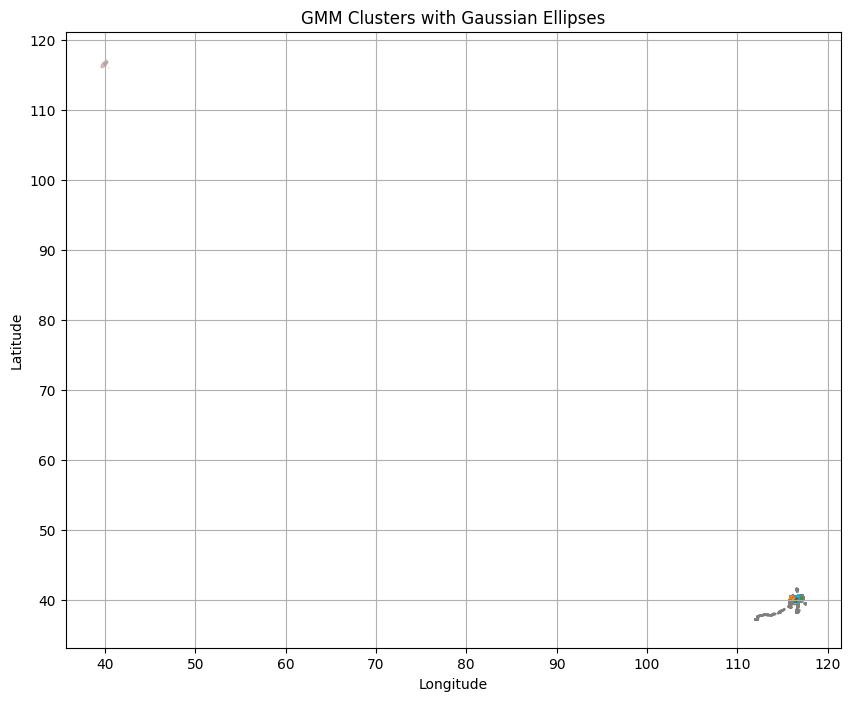

In [13]:
import numpy as np
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(10, 8))
colors = sns.color_palette('tab10', 8)

for i in range(8):
    mean = gmm.means_[i]
    cov = gmm.covariances_[i]
    v, w = np.linalg.eigh(cov)
    v = 2.0 * np.sqrt(v)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.degrees(np.arctan2(u[1], u[0]))
    ell = patches.Ellipse(mean, v[0], v[1], angle=angle, color=colors[i], alpha=0.3)
    ax.add_patch(ell)

ax.scatter(X[:, 1], X[:, 0], s=1, c=df_clean['gmm_cluster'], cmap='tab10')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('GMM Clusters with Gaussian Ellipses')
plt.grid(True)
plt.show()

Group by taxi ID to build trajectories

In [14]:
df_clean.groupby('taxiid')['gmm_cluster'].apply(list)

taxiid
84       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
146      [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...
162      [6, 6, 6, 0, 0, 0, 0, 0, 6, 6, 0, 0, 6, 6, 6, ...
168      [0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, ...
200      [0, 0, 0, 0, 0, 6, 3, 6, 6, 0, 0, 0, 0, 0, 0, ...
                               ...                        
10246    [0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 6, 6, ...
10279    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
10296    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
10314    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 0, 0, ...
10337    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: gmm_cluster, Length: 483, dtype: object

**Summary**
|Thing|	Behavior in GMM|
|:------|:-------------|
|Number of clusters (k)|	Fixed to 8 by you|
|Total taxi IDs|	Not used directly in clustering|
|Each taxi's data|	Distributed across 8 clusters by location|
|Outcome|	8 spatial clusters — “zones” in the city|

**📊 GMM Statistics Summary** <br>
1. 📍 Cluster Counts (How many points per cluster) <br>

In [15]:
print("📌 GMM Cluster Counts:")
print(df_clean['gmm_cluster'].value_counts().sort_index())

📌 GMM Cluster Counts:
gmm_cluster
0    252063
1     42966
2     10396
3     44403
4     24538
5     11855
6     34920
7     19322
Name: count, dtype: int64


# Summarry <br>

📌 Interpretation of GMM Cluster Counts <br>
Cluster	Points	% of Total	Observation <br>
0	252,063	~53%	Dominant cluster — likely a high-density area (e.g., city center) <br>
1	42,966	~9%	Medium-density zone <br>
2	10,396	~2%	Small cluster — possibly a fringe area <br>
3	44,403	~9%	Medium-density zone <br>
4	24,538	~5%	Lower density, but still significant <br>
5	11,855	~2.5%	Smaller cluster <br>
6	34,920	~7%	Mid-sized cluster <br>
7	19,322	~4%	Possibly a local hotspot <br>

🔎 What to Look For:<br>
Cluster 0: This zone dominates and could represent:<br>
Central business district <br>
High GPS sampling frequency <br>
Repetitive taxi trips (e.g., airport ↔ city) <br>
Small clusters (2, 5, 7): Worth inspecting spatially to check:<br>
Are they real spatial zones? <br>
Or artifacts (sparse or boundary points)?<br>

🔹 1. Print & Map Centroids

In [16]:
centroids = pd.DataFrame(gmm.means_, columns=['latitude', 'longitude'])
centroids.index.name = 'gmm_cluster'
print(centroids)

              latitude   longitude
gmm_cluster                       
0            39.923526  116.406337
1            40.432373  115.974988
2            40.142633  117.107250
3            40.079290  116.296721
4            40.120149  116.578114
5            39.933293  116.492640
6            39.950814  116.350472
7            40.102549  116.688357


🔹 3. Analyze Taxi Distribution per Cluster

In [17]:
taxi_per_cluster = df_clean.groupby('gmm_cluster')['taxiid'].nunique()
print("🚖 Unique Taxis per Cluster:")
print(taxi_per_cluster)

🚖 Unique Taxis per Cluster:
gmm_cluster
0    476
1     10
2     81
3    117
4    291
5    175
6    356
7    211
Name: taxiid, dtype: int64


🔹 4. Prepare Sequence for LSTM/GRU - Group by taxi and time, and prepare:

In [ ]:
df_clean.sort_values(by=['taxiid', 'timestamp'], inplace=True)
taxi_trajectories = df_clean.groupby('taxiid')['gmm_cluster'].apply(list)

# ✅ What It Represents
# Each taxi has a timeline of GPS points. GMM assigns each point to a cluster (zone).
# So the list [2, 2, 3, 3, 0, 1, 1] might represent:
# The path a taxi followed through city zones
# A simplified version of the raw GPS path

🔹 Step 2: Code to Visualize GMM Clusters on Interactive Map

In [36]:
import folium
from IPython.display import display

# Center map
center_lat = df_clean['latitude'].mean()
center_lon = df_clean['longitude'].mean()

# Create map with smaller size
m = folium.Map(location=[center_lat, center_lon], zoom_start=11,
               width='700px', height='450px')

# Define 8 cluster colors
colors = ['red', 'blue', 'green', 'orange', 'purple', 'darkred', 'cadetblue', 'darkgreen']
unique_clusters = sorted(df_clean['gmm_cluster'].unique())
color_map = {i: colors[i % len(colors)] for i in unique_clusters}

# Add sample markers per cluster
for cluster_id in unique_clusters:
    sample_data = df_clean[df_clean['gmm_cluster'] == cluster_id].sample(
        n=min(500, df_clean['gmm_cluster'].value_counts()[cluster_id]),
        random_state=42
    )
    
    for _, row in sample_data.iterrows():
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=2,
            color=color_map[cluster_id],
            fill=True,
            fill_color=color_map[cluster_id],
            fill_opacity=0.6,
            weight=0
        ).add_to(m)

# ✅ Add floating HTML legend
legend_html = '''
<div style="
    position: fixed;
    top: 10px; right: 10px; 
    background-color: white;
    border: 1px solid grey;
    padding: 8px;
    font-size: 13px;
    box-shadow: 2px 2px 6px rgba(0,0,0,0.3);
    z-index: 1000;
">
<b>GMM Cluster Colors</b><br>
''' + ''.join([
    f'<span style="color:{color_map[i]}">&#9679;</span> Cluster {i}<br>'
    for i in unique_clusters
]) + '</div>'

m.get_root().html.add_child(folium.Element(legend_html))

# Display the map
display(m)



✅ Step 1: Save GMM Output to CSV

In [53]:
# Make sure these columns exist in your DataFrame
columns_to_save = [
    'taxiid',
    'timestamp',
    'longitude',
    'latitude',
    'ts_num',
    'gmm_cluster',
    'gmm_cluster_confidence',
    'is_outlier'  # from HDBSCAN, optional
]

# Filter high-confidence data (optional, or save full)
# df_to_save = df[df['gmm_confidence'] >= 0.6].copy()
df_to_save = df_clean.copy() 

# Save to file
df_to_save[columns_to_save].to_csv('D:/Research/Papers/repo/IEEE_SubResizeUsingAIForFleetVehicles/Output/gmm_cluster_output.csv', index=False)
# print("✅ GMM output saved to gmm_cluster_output.csv")